# Cell Type Project Dataset I: Ephys Features

The Allen Software Development Kit (Allen SDK) is a source code for processing Allen Brain Atlas data, which includes the Cell Types Database. Electrophysiologcal characterizations of human neurons can be found in the Allen Cell Types. 

We can download the data from Allen Cell Types Database by importing the "Cell Types Cache" class, which will provide a Python interface for downloading data from the database. To access the database, we will then import CellTypesApi and initialize it as 'ctc'. 

In [1]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi

import pandas as pd

import requests
import json

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

The 'get_cells' method downloads the metadata of all cells in the databse. We will filter for human cells by specifying the species as 'HUMAN' and assign the output to 'human_cells'. 


In [2]:
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
human_cells = ctc.get_cells(species=[CellTypesApi.HUMAN])

Importing pandas allows us to visualize the data downloaded from the database in an organized manner by allowing the conversion of the human_cells output into a dataframe. 'pd.Dataframe' converts 'human_cells' to a Pandas dataframe. Our data will be organized by subject id by using the 'set_index' method to reassign the indices of the rows in our dataframe. 

In [3]:
# setting up a dataframe that contains only human cell information
human_df = pd.DataFrame(human_cells)
human_df = human_df.set_index('id')
human_df.head()

,reporter_status,cell_soma_location,species,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,apical,reconstruction_type,disease_state,donor_id,structure_hemisphere,normalized_depth
id,,,,,,,,,,,,,,,
525011903,None,"[273.0, 354.0, 216.0]",Homo Sapiens,H16.03.003.01.14.02,3,12113,FroL,,spiny,intact,None,epilepsy,524848408,right,NaN
528642047,None,"[69.0, 254.0, 96.0]",Homo Sapiens,H16.06.009.01.02.06.05,5,12141,MTG,,aspiny,NA,None,epilepsy,528574320,left,NaN
537256313,None,"[322.0, 255.0, 92.0]",Homo Sapiens,H16.03.006.01.05.02,4,12141,MTG,,spiny,truncated,None,epilepsy,536912860,right,NaN
519832676,None,"[79.0, 273.0, 91.0]",Homo Sapiens,H16.03.001.01.09.01,3,12141,MTG,,spiny,truncated,full,epilepsy,518641172,left,0.290951
596020931,None,"[66.0, 220.0, 105.0]",Homo Sapiens,H17.06.009.11.04.02,4,12141,MTG,,aspiny,NA,full,tumor,595954915,left,0.497825


Since our project is interestd in hippocampal spiny neurons, we want to focus on the values under the columns 'structure_area_abbrev' and 'dendrite type'. We want these columns to contain the values 'MTG' and 'spiny,' respectively. To filter through the dataframe, we can use boolean indexing. The following lines of codes makes new dataframes from the 'human_df' dataframe where the values under our two columns of interest equals the values we want.  

In [4]:
#First we made a new dataframe from 'human_df' with the 'structure_area_abbrev' containing all 'MTG' values
MTG_df = human_df[human_df['structure_area_abbrev']=='MTG']

#From MTG_df, we made a new dataframe with 'dendrite_type' colunn containing all 'spiny' values
MTG_spiny_df = MTG_df[MTG_df['dendrite_type']=='spiny']
MTG_spiny_df.head()

,reporter_status,cell_soma_location,species,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,apical,reconstruction_type,disease_state,donor_id,structure_hemisphere,normalized_depth
id,,,,,,,,,,,,,,,
537256313,None,"[322.0, 255.0, 92.0]",Homo Sapiens,H16.03.006.01.05.02,4,12141,MTG,,spiny,truncated,None,epilepsy,536912860,right,NaN
519832676,None,"[79.0, 273.0, 91.0]",Homo Sapiens,H16.03.001.01.09.01,3,12141,MTG,,spiny,truncated,full,epilepsy,518641172,left,0.290951
545608578,None,"[312.0, 280.0, 89.0]",Homo Sapiens,H16.03.010.13.06.01,3,12141,MTG,,spiny,intact,None,epilepsy,545510854,right,NaN
561467633,None,"[79.0, 273.0, 86.0]",Homo Sapiens,H16.06.013.12.08.05,3,12141,MTG,,spiny,truncated,None,epilepsy,561414332,left,NaN
528706755,None,"[70.0, 260.0, 108.0]",Homo Sapiens,H16.06.009.01.01.15.01,2,12141,MTG,,spiny,intact,dendrite-only,epilepsy,528574320,left,0.134667


Now we need to get the electrophysiological properties data of the cells we're interested in. This can be done by using the 'get_ephys_feature()' method on the cell types cache instance we made earlier. Like before, we converted the output into a dataframe and set the 'specimen_id' column as the index of the dataframe. Indexing both of our dataframes with 'specimen_id' will allow us to merge the two dataframes together in the next step. 

In [5]:
ephys_features = pd.DataFrame(ctc.get_ephys_features()).set_index('specimen_id')
#We want to display column names so we know which column contains the data points we are intersted in later
ephys_features.head()

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
specimen_id,,,,,,,,,,,,,,,,,,,,,
529878215,NaN,134.700000,22.697498,8.335459e-02,1.187680,13.295200,1.025916,-56.375004,-57.385420,-57.431251,...,13.295680,1.134780,-56.593754,-57.739586,-74.143753,3.029695,3.061646,2.969821,-80.468750,-73.553391
548459652,NaN,NaN,-24.887498,-3.913630e-19,1.099840,20.650105,1.025460,-54.000000,-54.828129,-54.656254,...,20.650735,1.160940,-55.406254,-55.242191,-73.500000,2.441895,2.245653,2.231575,-84.406258,-73.056595
579978640,0.009770,39.044800,-46.765002,5.267857e-01,1.157840,2.551310,1.025387,-59.500000,-58.234378,-59.940975,...,2.551960,1.089851,-60.062500,-58.570314,-61.371531,2.023762,2.162878,2.006406,-93.375008,-60.277321
439024551,-0.007898,117.816429,5.996250,1.542553e-01,1.989165,9.572025,1.028733,-47.531250,-50.359375,-65.500000,...,9.576308,1.423229,-49.406254,-52.718752,-75.273443,3.105931,3.491663,1.733896,-87.656250,-75.205559
515188639,0.022842,68.321429,14.910000,1.714041e-01,1.081980,2.462880,1.025620,-48.437504,-46.520837,-51.406253,...,2.490433,1.479690,-53.000004,-54.645837,-64.250003,3.285760,3.363504,4.234701,-81.625008,-63.474991


The two dataframes we have now are 'MTG_spiny_df' and 'ephys_features.' We are only interested in the data in 'ephys_features' that correspond with the specimen_id values in 'MTG_spiny_df.' Since we indexed both dataframes by specimen_id, we can combine the two dataframes into a new dataframe where only data entries with the same index values across the two dataframes are kept. 

In [6]:
MTGspiny_ephys_features = MTG_spiny_df.join(ephys_features)

print(MTGspiny_ephys_features.columns)
MTGspiny_ephys_features.head()

Index(['reporter_status', 'cell_soma_location', 'species', 'name',
       'structure_layer_name', 'structure_area_id', 'structure_area_abbrev',
       'transgenic_line', 'dendrite_type', 'apical', 'reconstruction_type',
       'disease_state', 'donor_id', 'structure_hemisphere', 'normalized_depth',
       'adaptation', 'avg_isi', 'electrode_0_pa', 'f_i_curve_slope',
       'fast_trough_t_long_square', 'fast_trough_t_ramp',
       'fast_trough_t_short_square', 'fast_trough_v_long_square',
       'fast_trough_v_ramp', 'fast_trough_v_short_square', 'has_burst',
       'has_delay', 'has_pause', 'id', 'input_resistance_mohm', 'latency',
       'peak_t_long_square', 'peak_t_ramp', 'peak_t_short_square',
       'peak_v_long_square', 'peak_v_ramp', 'peak_v_short_square',
       'rheobase_sweep_id', 'rheobase_sweep_number', 'ri', 'sag', 'seal_gohm',
       'slow_trough_t_long_square', 'slow_trough_t_ramp',
       'slow_trough_t_short_square', 'slow_trough_v_long_square',
       'slow_trough_v_r

,reporter_status,cell_soma_location,species,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,apical,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
id,,,,,,,,,,,,,,,,,,,,,
537256313,None,"[322.0, 255.0, 92.0]",Homo Sapiens,H16.03.006.01.05.02,4,12141,MTG,,spiny,truncated,...,5.694547,1.389900,-52.125004,-51.520836,-72.900002,3.121182,3.464528,3.054681,-87.531250,-72.628105
519832676,None,"[79.0, 273.0, 91.0]",Homo Sapiens,H16.03.001.01.09.01,3,12141,MTG,,spiny,truncated,...,9.962780,1.211020,-53.875004,-52.416668,-73.693753,4.574865,3.817988,4.980603,-84.218758,-72.547661
545608578,None,"[312.0, 280.0, 89.0]",Homo Sapiens,H16.03.010.13.06.01,3,12141,MTG,,spiny,intact,...,22.069340,1.112633,-54.343754,-54.968751,-75.156258,3.675430,3.665890,3.586321,-78.500000,-74.496262
561467633,None,"[79.0, 273.0, 86.0]",Homo Sapiens,H16.06.013.12.08.05,3,12141,MTG,,spiny,truncated,...,6.479140,1.174147,-60.312504,-57.989586,-71.020838,4.149998,3.667004,3.929834,-78.312500,-69.626610
528706755,None,"[70.0, 260.0, 108.0]",Homo Sapiens,H16.06.009.01.01.15.01,2,12141,MTG,,spiny,intact,...,10.173433,1.670800,-47.062500,-52.302085,-72.343750,2.806181,3.007196,2.592416,-82.593758,-72.490135


In [7]:
# RMA for firing rate
service = "http://api.brain-map.org/api/v2/data/query.json?criteria="

specimen_id = list(MTGspiny_ephys_features.index)
print(type(specimen_id[0]))
avg_fr = []

for specimen in specimen_id:
    donor_result = requests.get("%smodel::ApiCellTypesSpecimenDetail, rma::criteria, \
    specimen[id$eq%s]" % (service, specimen)).json()
    avg_fr.append(donor_result['msg'][0]['ef__avg_firing_rate'])
    
    
MTGspiny_ephys_features['avg_fr'] = avg_fr
MTGspiny_ephys_features

<class 'int'>


,reporter_status,cell_soma_location,species,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,apical,...,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest,avg_fr
id,,,,,,,,,,,,,,,,,,,,,
537256313,None,"[322.0, 255.0, 92.0]",Homo Sapiens,H16.03.006.01.05.02,4,12141,MTG,,spiny,truncated,...,1.389900,-52.125004,-51.520836,-72.900002,3.121182,3.464528,3.054681,-87.531250,-72.628105,12.919897
519832676,None,"[79.0, 273.0, 91.0]",Homo Sapiens,H16.03.001.01.09.01,3,12141,MTG,,spiny,truncated,...,1.211020,-53.875004,-52.416668,-73.693753,4.574865,3.817988,4.980603,-84.218758,-72.547661,4.066584
545608578,None,"[312.0, 280.0, 89.0]",Homo Sapiens,H16.03.010.13.06.01,3,12141,MTG,,spiny,intact,...,1.112633,-54.343754,-54.968751,-75.156258,3.675430,3.665890,3.586321,-78.500000,-74.496262,NaN
561467633,None,"[79.0, 273.0, 86.0]",Homo Sapiens,H16.06.013.12.08.05,3,12141,MTG,,spiny,truncated,...,1.174147,-60.312504,-57.989586,-71.020838,4.149998,3.667004,3.929834,-78.312500,-69.626610,27.533040
528706755,None,"[70.0, 260.0, 108.0]",Homo Sapiens,H16.06.009.01.01.15.01,2,12141,MTG,,spiny,intact,...,1.670800,-47.062500,-52.302085,-72.343750,2.806181,3.007196,2.592416,-82.593758,-72.490135,5.936480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528636794,None,"[69.0, 254.0, 96.0]",Homo Sapiens,H16.06.009.01.02.03.01,5,12141,MTG,,spiny,truncated,...,1.669760,-54.531254,-56.062504,-70.031258,3.200447,3.496134,3.321839,-87.281258,-69.768448,11.369744
611823070,None,"[333.0, 236.0, 122.0]",Homo Sapiens,H17.06.012.14.10.02,4,12141,MTG,,spiny,truncated,...,1.274645,-56.468750,-58.125002,-61.960942,3.238006,3.082875,3.022499,-92.000008,-61.007416,14.107434
508298270,None,"[325.0, 257.0, 102.0]",Homo Sapiens,H16.06.004.01.04.05,3,12141,MTG,,spiny,intact,...,1.025320,-46.562504,-51.989585,-47.890627,2.386624,2.421567,2.337120,-86.000000,-74.491547,93.196645


As our project is interested in looking at the excitability of neurons, we want the values under the columns 'RHEOBASE ONE HERE' and 'AVG FIRING RATE ONE HERE'. We made a new dataframe containing only these two columns and also the human donor name so we can extract information about donor age later.

In [8]:
final_ephys_df = MTGspiny_ephys_features[['id', 'avg_isi', \
                                          'adaptation', 'f_i_curve_slope', 'rheobase_sweep_id',\
                                          'rheobase_sweep_number', 'donor_id', 'avg_fr']] 
final_ephys_df = final_ephys_df.set_index('donor_id').sort_index()
final_ephys_df.head(15)


,id,avg_isi,adaptation,f_i_curve_slope,rheobase_sweep_id,rheobase_sweep_number,avg_fr
donor_id,,,,,,,
487502058,488401731,74.421250,0.022702,0.183333,488401175,31,13.437022
487502058,488393273,107.981875,0.033502,0.146875,488393014,62,9.260813
487502058,488412388,136.225833,0.033226,0.109603,488405966,41,7.340752
487502058,508991448,NaN,NaN,0.016667,488708035,73,NaN
487502058,488419346,320.915000,0.891342,0.067527,488419098,63,3.116090
488771222,500861768,53.234118,0.034370,0.231250,500861167,27,18.784946
488771222,500861836,110.320000,0.153688,0.143875,500861306,31,9.064540
488771222,489390373,54.640000,NaN,0.025893,489344124,52,18.301611
500830126,500990487,102.300000,0.158770,0.142738,500988162,43,9.775171


Lastly, we want to acquire the age of all the subject ids in our dataframe. We will search for subject age by using the donor profile page (https://celltypes.brain-map.org/donors) which is sorted by donor name and includes information about donor ages. 

In [9]:
#run an RMA query to get the human donor age info corresponding to the recordings on MTG spiny neurons 
donor_id = final_ephys_df.index.values.tolist()
donor_age_yrs = []
#print(donor_id)

for each_id in donor_id:
    donor_result = requests.get("%smodel::ApiCellTypesSpecimenDetail,\
        rma::criteria, specimen[donor_id$eq%s]" % (service, each_id)).json()
    
    each_age = donor_result['msg'][0]['donor__age']
    donor_age_yrs.append(int(each_age.split(' ')[0])) 
    
print(donor_age_yrs)

[65, 65, 65, 65, 65, 19, 19, 19, 35, 31, 31, 31, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 39, 39, 39, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 31, 31, 31, 31, 31, 31, 48, 48, 42, 42, 34, 34, 34, 34, 34, 34, 34, 34, 23, 23, 23, 23, 23, 23, 23, 23, 23, 61, 61, 61, 61, 61, 61, 61, 61, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 35, 35, 35, 35, 35, 35, 35, 35, 35, 60, 60, 60, 60, 60, 60, 27, 27, 60, 52, 52, 18, 18, 18, 18, 38, 38, 23, 23, 23, 30, 30]


In [11]:
# merge donor age info with the ephys dataframe that we have
final_ephys_df['donor_age_yrs'] = donor_age_yrs
final_ephys_df.head(10)

# seperate donor age into two groups: younger and older. NOT SURE IF VERY NECESSARY?
older_donor = []
younger_donor = []
age_category = []

for age in donor_age_yrs:
    if age < 41:
        if age > 20: 
            older_donor.append(age)
            age_category.append('older') 
        else:
            younger_donor.append(age)
            age_category.append('younger')
    else:
        age_category.append ('out_of_range')    
        
print(len(older_donor), len(younger_donor))

final_ephys_df['age_category'] = age_category
final_ephys_df

155 7


,id,avg_isi,adaptation,f_i_curve_slope,rheobase_sweep_id,rheobase_sweep_number,avg_fr,donor_age_yrs,age_category
donor_id,,,,,,,,,
487502058,488401731,74.421250,0.022702,0.183333,488401175,31,13.437022,65,out_of_range
487502058,488393273,107.981875,0.033502,0.146875,488393014,62,9.260813,65,out_of_range
487502058,488412388,136.225833,0.033226,0.109603,488405966,41,7.340752,65,out_of_range
487502058,508991448,NaN,NaN,0.016667,488708035,73,NaN,65,out_of_range
487502058,488419346,320.915000,0.891342,0.067527,488419098,63,3.116090,65,out_of_range
...,...,...,...,...,...,...,...,...,...
611526465,611988589,175.060000,0.365937,0.090625,611961288,37,5.712327,23,older
611526465,611940594,70.884615,0.033519,0.240933,611914827,37,14.107434,23,older
611526465,611940196,42.649091,0.008669,0.302578,611914340,43,23.447159,23,older


Text(0.5, 1.0, 'Distribution of Average Firing Rate')

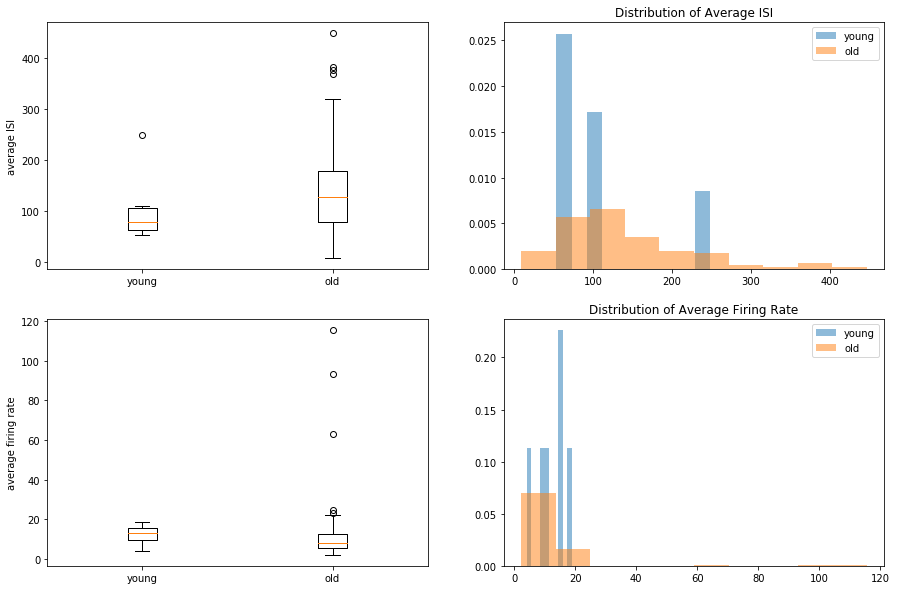

In [17]:
# plot several boxplots data against age category
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

final_ephys_df = final_ephys_df.dropna()

young_group = final_ephys_df[final_ephys_df['age_category'] == 'younger']
old_group = final_ephys_df[final_ephys_df['age_category'] == 'older']

# plot for average isi
young_isi = young_group['avg_isi']
old_isi = old_group['avg_isi']
    
axes[0, 0].boxplot([young_isi, old_isi])
axes[0, 0].set_xticklabels(['young', 'old'])
axes[0, 0].set_ylabel('average ISI')

# plot average isi distribution
axes[0, 1].hist(young_isi, alpha = 0.5, density = True)
axes[0, 1].hist(old_isi, alpha = 0.5, density = True)
axes[0, 1].legend(['young', 'old'])
axes[0, 1].set_title('Distribution of Average ISI')

#plot for average firing rate
young_fr = young_group['avg_fr']
old_fr = old_group['avg_fr']
    
axes[1, 0].boxplot([young_fr, old_fr])
axes[1, 0].set_xticklabels(['young', 'old'])
axes[1, 0].set_ylabel('average firing rate')

# plot average firing rate distribution
axes[1, 1].hist(young_fr, alpha = 0.5, density = True)
axes[1, 1].hist(old_fr, alpha = 0.5, density = True)
axes[1, 1].legend(['young', 'old'])
axes[1, 1].set_title('Distribution of Average Firing Rate')

In [18]:
# doing t-test to determine significance between age groups
print(stats.mannwhitneyu(young_isi, old_isi))
print(stats.mannwhitneyu(young_fr, old_fr))

MannwhitneyuResult(statistic=219.0, pvalue=0.1064892964606044)
MannwhitneyuResult(statistic=219.0, pvalue=0.1064892964606044)


In [ ]:
# making scatterplots for the data that we want to see
## maybe not super necessary?

fig, axes = plt.subplots(2, 2, figsize = (15, 10))
axes[0, 0].scatter(final_ephys_df['donor_age_yrs'], final_ephys_df['avg_isi'])
axes[0, 0].set_ylabel('Average ISI')
axes[0, 0].set_xlabel('Donor Age / yrs')

axes[0, 1].hist(final_ephys_df['avg_isi'], density = True)
axes[0, 1].set_title('Distribution of Average ISI')

axes[1, 0].scatter(final_ephys_df['donor_age_yrs'], final_ephys_df['f_i_curve_slope'])
axes[1, 0].set_ylabel('F/I Curve')
axes[1, 0].set_xlabel('Donor Age / yrs')

axes[1, 1].hist(final_ephys_df['f_i_curve_slope'], density = True)
axes[1, 1].set_title('Distribution of F/I curve slope')


#print(stats.mannwhitneyu())